## SPESIFIKASI MODEL
### Arsitektur Model
- **Model:** `Faster R-CNN` - `ResNet-50` backbone, `Feature Pyramid Network (FPN)`
- **Pretrained dataset:** COCO
- **Fine-tuning dataset:** PASCAL VOC 2007
__ __
### Dataset
- **Training set:** VOC 2007 `trainval` (5,011 gambar)
- **Validation/Test set:** VOC 2007 `test` (4,952 gambar)
__ __
### Training Setup
- **Jumlah Epoch:** 5
- **Optimizer:** SGD (default Faster R-CNN settings)
- **Learning rate:** 0.005
- **Ukuran Batch:** 4
- **Scheduler:** StepLR (γ=0.1, step_size=3)
- **Accelerator:** GPU (P100)
__ __


In [1]:
# === Section 1: Imports and Configuration ===
import torch
import time
import random
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms.functional as F
from torchvision.datasets import VOCDetection
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Config
NUM_EPOCHS = 5
BATCH_SIZE = 4
NUM_WORKERS = 4
PATIENCE = 2
PRINT_INTERVAL = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Config => epochs: {NUM_EPOCHS}, batch_size: {BATCH_SIZE}, workers: {NUM_WORKERS}, patience: {PATIENCE}")
print(f"Using device: {DEVICE}")

Config => epochs: 5, batch_size: 4, workers: 4, patience: 2
Using device: cuda


In [2]:
# === Section 2: Data Preparation & Augmentations ===
VOC_CLASSES = [
    "aeroplane","bicycle","bird","boat","bottle","bus","car","cat",
    "chair","cow","diningtable","dog","horse","motorbike","person",
    "pottedplant","sheep","sofa","train","tvmonitor"
]

def prepare_sample(img, target):
    # Random horizontal flip
    if random.random() < 0.5:
        w = img.width
        img = F.hflip(img)
        objs = target['annotation']['object']
        if not isinstance(objs, list): objs = [objs]
        for o in objs:
            xmin, xmax = int(o['bndbox']['xmin']), int(o['bndbox']['xmax'])
            o['bndbox']['xmin'] = w - xmax
            o['bndbox']['xmax'] = w - xmin
    # Random color jitter
    if random.random() < 0.5:
        img = F.adjust_brightness(img, random.uniform(0.8,1.2))
        img = F.adjust_contrast(img,   random.uniform(0.8,1.2))
        img = F.adjust_saturation(img, random.uniform(0.8,1.2))
    # To tensor & parse boxes
    img_tensor = F.to_tensor(img)
    objs = target['annotation']['object']
    if not isinstance(objs, list): objs = [objs]
    boxes = torch.tensor([
        [int(o['bndbox']['xmin']), int(o['bndbox']['ymin']),
         int(o['bndbox']['xmax']), int(o['bndbox']['ymax'])]
        for o in objs
    ], dtype=torch.float32)
    labels = torch.tensor([
        VOC_CLASSES.index(o['name'])+1 for o in objs
    ], dtype=torch.int64)
    return img_tensor, {"boxes": boxes, "labels": labels}

def collate_fn(batch):
    return tuple(zip(*batch))

# Load datasets
train_root = "/kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007"
test_root  = "/kaggle/input/pascal-voc-2007/VOCtest_06-Nov-2007"
train_ds = VOCDetection(root=train_root, year='2007', image_set='trainval', download=False, transforms=prepare_sample)
val_ds   = VOCDetection(root=test_root, year='2007', image_set='test',     download=False, transforms=prepare_sample)
print("Train size:", len(train_ds), "Val size:", len(val_ds))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=1,          shuffle=False, collate_fn=collate_fn, num_workers=2)
total_batches = len(train_loader)
print(f"Batches per epoch: {total_batches}")

Train size: 5011 Val size: 4952
Batches per epoch: 1253


In [3]:
# === Section 3: Model Setup and Backbone Freezing ===
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights  # import weights enum
model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)  # replaced deprecated pretrained=True with weights argument
in_feat = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor.cls_score = torch.nn.Linear(in_feat, len(VOC_CLASSES)+1)
model.roi_heads.box_predictor.bbox_pred  = torch.nn.Linear(in_feat, 4*(len(VOC_CLASSES)+1))
model.to(DEVICE)
# Freeze backbone initially
for p in model.backbone.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 214MB/s] 


In [4]:
# === Section 4: Optimizer, Scheduler, AMP ===
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=PATIENCE)
scaler = GradScaler()

/tmp/ipykernel_35/301791028.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [5]:
# === Section 5: Training, Validation, Scheduler & Plotting ===

# Initialize history and metrics
history = {
    'total_loss': [], 'cls_loss': [], 'box_loss': [],
    'obj_loss': [], 'rpn_box_loss': [], 'val_loss': [], 'val_map50': []
}
best_val = float('inf')
epochs_no_improve = 0

from torchmetrics.detection.mean_ap import MeanAveragePrecision
val_metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5])

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()
    model.train()
    running = {'total': 0, 'cls': 0, 'box': 0, 'obj': 0, 'rpn': 0}
    print(f"\n=== Epoch {epoch}/{NUM_EPOCHS} ===")

    # Unfreeze backbone after first epoch
    if epoch == 2:
        for p in model.backbone.parameters():
            p.requires_grad = True

    # --- Training Pass ---
    for batch_idx, (imgs, targets) in enumerate(train_loader, start=1):
        imgs = [im.to(DEVICE) for im in imgs]
        tgts = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        with autocast():
            loss_dict = model(imgs, tgts)
            loss = sum(loss for loss in loss_dict.values())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate losses
        running['cls']   += loss_dict['loss_classifier'].item()
        running['box']   += loss_dict['loss_box_reg'].item()
        running['obj']   += loss_dict['loss_objectness'].item()
        running['rpn']   += loss_dict['loss_rpn_box_reg'].item()
        running['total'] += loss.item()

        if batch_idx % PRINT_INTERVAL == 0 or batch_idx == total_batches:
            print(f"Batch {batch_idx}/{total_batches} - Loss: {loss.item():.4f}")

    # Record training metrics
    nB = total_batches
    history['cls_loss'].append(running['cls'] / nB)
    history['box_loss'].append(running['box'] / nB)
    history['obj_loss'].append(running['obj'] / nB)
    history['rpn_box_loss'].append(running['rpn'] / nB)
    history['total_loss'].append(running['total'] / nB)
    print(f"Epoch {epoch} done in {(time.time() - start_time)/60:.1f}m, "
          f"avg total loss: {history['total_loss'][-1]:.4f}")

    # --- Validation Pass ---
    model.eval()
    val_running = 0
    val_metric.reset()
    with torch.no_grad():
        for imgs, tgts in val_loader:
            imgs = [im.to(DEVICE) for im in imgs]
            tgts = [{k: v.to(DEVICE) for k, v in t.items()} for t in tgts]

            # validation loss
            model.train()
            loss_dict = model(imgs, tgts)
            val_running += sum(l.item() for l in loss_dict.values())

            # predictions for mAP
            model.eval()
            preds = model(imgs)
            val_metric.update(preds, tgts)

    val_loss = val_running / len(val_loader)
    history['val_loss'].append(val_loss)
    val_map50 = val_metric.compute()['map_50'].item()
    history['val_map50'].append(val_map50)
    print(f"Val loss: {val_loss:.4f}, mAP@0.5: {val_map50:.4f}")

    # --- Scheduler & Early Stopping ---
    scheduler.step(val_loss)
    if val_loss < best_val:
        best_val = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered")
            break


=== Epoch 1/5 ===


/tmp/ipykernel_35/3970082013.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch 100/1253 - Loss: 0.1777
Batch 200/1253 - Loss: 0.5678
Batch 300/1253 - Loss: 0.3470
Batch 400/1253 - Loss: 0.1872
Batch 500/1253 - Loss: 0.4265
Batch 600/1253 - Loss: 0.2029
Batch 700/1253 - Loss: 0.3564
Batch 800/1253 - Loss: 0.2148
Batch 900/1253 - Loss: 0.1823
Batch 1000/1253 - Loss: 0.4678
Batch 1100/1253 - Loss: 0.4993
Batch 1200/1253 - Loss: 0.3294
Batch 1253/1253 - Loss: 0.3733
Epoch 1 done in 8.2m, avg total loss: 0.4002
Val loss: 0.3415, mAP@0.5: 0.7312

=== Epoch 2/5 ===
Batch 100/1253 - Loss: 0.4478
Batch 200/1253 - Loss: 0.3485
Batch 300/1253 - Loss: 0.2557
Batch 400/1253 - Loss: 0.3479
Batch 500/1253 - Loss: 0.2899
Batch 600/1253 - Loss: 0.4669
Batch 700/1253 - Loss: 0.1271
Batch 800/1253 - Loss: 0.4898
Batch 900/1253 - Loss: 0.3200
Batch 1000/1253 - Loss: 0.4234
Batch 1100/1253 - Loss: 0.2454
Batch 1200/1253 - Loss: 0.1606
Batch 1253/1253 - Loss: 0.3207
Epoch 2 done in 19.9m, avg total loss: 0.3217
Val loss: 0.3235, mAP@0.5: 0.7656

=== Epoch 3/5 ===
Batch 100/1253 

In [6]:
# === Post-Training Evaluation (Avoiding Size Mismatch in Flip Merge) ===

from torchmetrics.detection.mean_ap import MeanAveragePrecision
import torchvision.transforms.functional as F

# Create a multi-IoU metric
multi_iou_metric = MeanAveragePrecision(
    iou_type='bbox',
    iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
)

model.eval()
multi_iou_metric.reset()

with torch.no_grad():
    for imgs, tgts in val_loader:
        # Move images & targets to device
        imgs = [im.to(DEVICE) for im in imgs]
        tgts = [{k: v.to(DEVICE) for k, v in t.items()} for t in tgts]

        # 1) Predictions on original images
        preds_orig = model(imgs)

        # 2) Optional: Predictions on flipped images (separate update)
        use_flip = True
        if use_flip:
            # Horizontally flip each image
            flipped_imgs = [F.hflip(im) for im in imgs]
            preds_flip = model(flipped_imgs)

            # “Un-flip” the boxes in preds_flip
            for pred, img in zip(preds_flip, flipped_imgs):
                W = img.shape[-1]
                boxes = pred['boxes']
                # swap x1,x2 = W - x2, W - x1
                pred['boxes'][:, [0, 2]] = W - boxes[:, [2, 0]]

            # Update metric on both original and flipped predictions
            # (They may have different numbers of boxes, but we update independently)
            multi_iou_metric.update(preds_orig, tgts)
            multi_iou_metric.update(preds_flip, tgts)
        else:
            # Only original predictions
            multi_iou_metric.update(preds_orig, tgts)

        # 3) (Optional) If you also want to filter low-confidence boxes,
        #    you can do that per-prediction before updating, for example:
        #
        # filtered_preds = []
        # for p in preds_orig:
        #     keep = p["scores"] > 0.3
        #     filtered_preds.append({
        #         "boxes":  p["boxes"][keep],
        #         "labels": p["labels"][keep],
        #         "scores": p["scores"][keep],
        #     })
        # multi_iou_metric.update(filtered_preds, tgts)

# 4) Compute and print all metrics
final_metrics = multi_iou_metric.compute()
print("\n=== Post-Eval Metrics ===")
for k, v in final_metrics.items():
    if isinstance(v, torch.Tensor):
        v = v.cpu().numpy()
        print(f"{k}: {v.round(4)}")
    else:
        print(f"{k}: {v}")



=== Post-Eval Metrics ===
map: 0.6651999950408936
map_50: 0.785099983215332
map_75: 0.47189998626708984
map_small: 0.319599986076355
map_medium: 0.5680000185966492
map_large: 0.7353000044822693
mar_1: 0.506600022315979
mar_10: 0.7957000136375427
mar_100: 0.8241000175476074
mar_small: 0.4959000051021576
mar_medium: 0.7671999931335449
mar_large: 0.8792999982833862
map_per_class: -1.0
mar_100_per_class: -1.0
classes: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


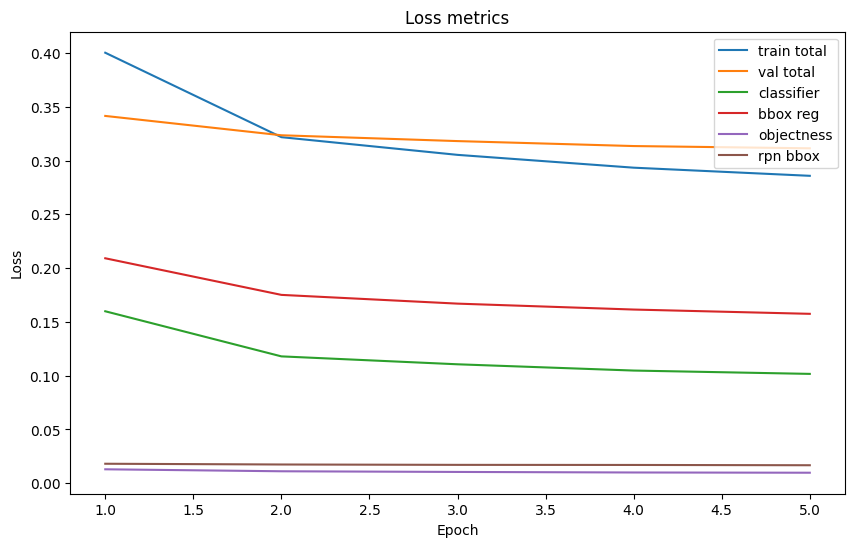

In [7]:
# --- Section 6: Plot losses ---
import matplotlib.pyplot as plt

epochs = range(1, len(history['total_loss']) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, history['total_loss'],     label='train total')
plt.plot(epochs, history['val_loss'],       label='val total')
plt.plot(epochs, history['cls_loss'],       label='classifier')
plt.plot(epochs, history['box_loss'],       label='bbox reg')
plt.plot(epochs, history['obj_loss'],       label='objectness')
plt.plot(epochs, history['rpn_box_loss'],   label='rpn bbox')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss metrics')
plt.show()

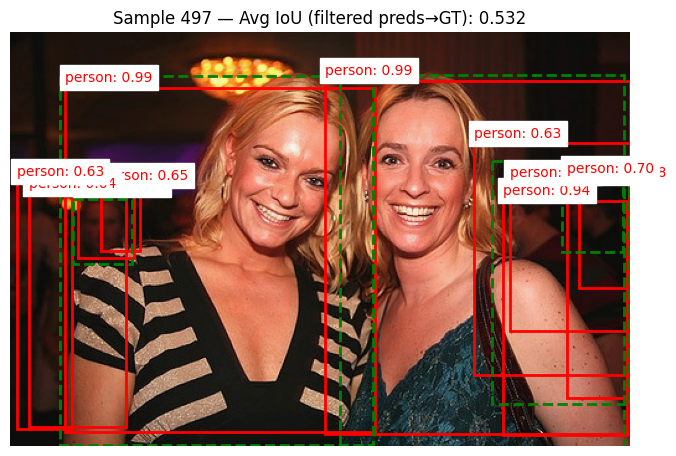

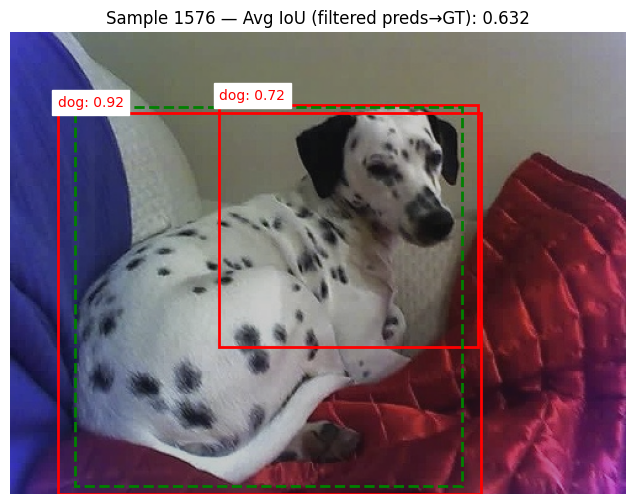

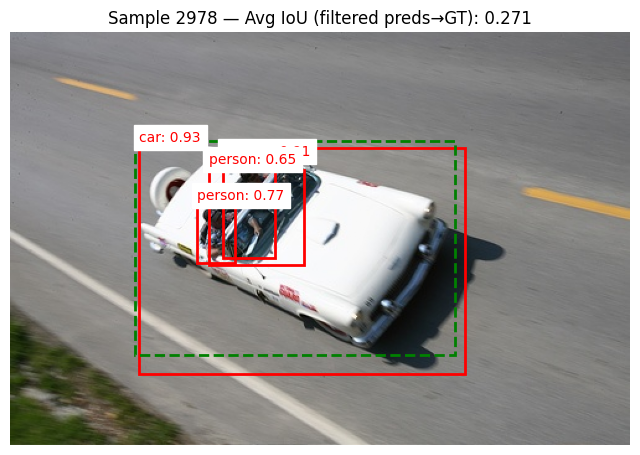

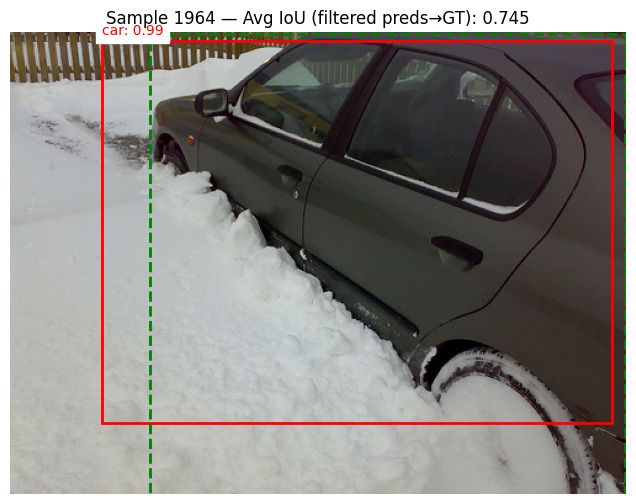

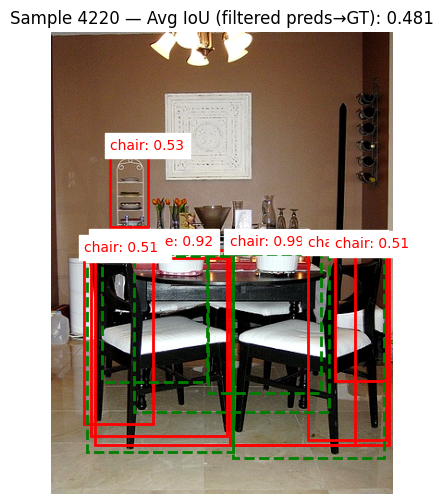

In [8]:
# === Section 7: Visualizing Test Results (Filtered & Annotated) ===

import random
import matplotlib.pyplot as plt
from torchvision.ops import box_iou
import torchvision.transforms.functional as F

# Ensure model is in eval mode
model.eval()

# Underlying VOC datasets
val_dataset = val_loader.dataset

# Number of examples to visualize
NUM_SAMPLES = 5
random_indices = random.sample(range(len(val_dataset)), k=NUM_SAMPLES)

# Confidence threshold for displayed boxes
SCORE_THRESH = 0.5

with torch.no_grad():
    for idx in random_indices:
        # 1) Load single sample
        img_tensor, target = val_dataset[idx]
        input_img = img_tensor.to(DEVICE).unsqueeze(0)

        # 2) Forward pass for raw predictions
        outputs = model(input_img)
        pred = outputs[0]

        # 3) Filter predictions by score
        keep = pred["scores"] > SCORE_THRESH
        filtered_boxes  = pred["boxes"][keep].cpu()
        filtered_scores = pred["scores"][keep].cpu()
        filtered_labels = pred["labels"][keep].cpu()

        # 4) Ground-truth boxes
        gt_boxes = target["boxes"].to(DEVICE)

        # 5) Compute IoU between filtered preds and GT
        if filtered_boxes.numel() and gt_boxes.numel():
            ious = box_iou(filtered_boxes.to(DEVICE), gt_boxes)
            iou_vals = ious.max(dim=1).values.cpu().tolist()
            avg_iou = sum(iou_vals) / len(iou_vals)
        else:
            avg_iou = 0.0

        # 6) Prepare image for plotting
        img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
        fig, ax = plt.subplots(1, figsize=(8, 6))
        ax.imshow(img_np)

        # 7) Draw filtered predicted boxes (red) with label and score text
        for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
            x1, y1, x2, y2 = box.numpy()
            cls_name = VOC_CLASSES[label.item() - 1]  # assuming VOC_CLASSES defined
            rect = plt.Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                fill=False,
                edgecolor="red",
                linewidth=2,
            )
            ax.add_patch(rect)
            ax.text(
                x1,
                y1 - 5,
                f"{cls_name}: {score:.2f}",
                color="red",
                fontsize=10,
                backgroundcolor="white",
            )

        # 8) Draw ground-truth boxes (green dashed)
        for box in gt_boxes.cpu():
            x1, y1, x2, y2 = box.numpy()
            rect = plt.Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                fill=False,
                edgecolor="green",
                linewidth=2,
                linestyle="--",
            )
            ax.add_patch(rect)

        ax.set_title(f"Sample {idx} — Avg IoU (filtered preds→GT): {avg_iou:.3f}")
        ax.axis("off")
        plt.show()
